Notebook to test the performance of HM4 on the test image set. Must generate the test data first, see the README.md file

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from expected_cost.ec import average_cost, CostMatrix
from torchmetrics.classification.calibration_error import MulticlassCalibrationError
from torchmetrics.functional.classification.calibration_error import _binning_bucketize

from hm4.VAE_classifier_248 import VAEClassifier
from hm4.preprocessing import CRISMData
from hm4.labelling import CLASS_NAMES
import hm4.labelling as labelling
from hm4.expected_cost import COST_ARRAY
from crism_ml.lab import relabel, ALIASES_TRAIN
from crism_ml.lab import CLASS_NAMES as PLEBANI_CLASS_NAMES

In [ ]:
RATIOED_TEST_SET_PATH = # Insert the path to the ratioed test set here
MODEL_WEIGHTS_PATH = # Insert the path to the saved model weights .pth file here

In [ ]:
dataset_for_recon = CRISMData(RATIOED_TEST_SET_PATH, transform=False, bands_to_use=(0, 248))

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/

In [3]:
model = VAEClassifier(n_blocks=1, n_conv_layers=1, zx_dim=16, zy_dim=16, n_classes=38)

In [ ]:

model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

[101690  85735  59483  20401]


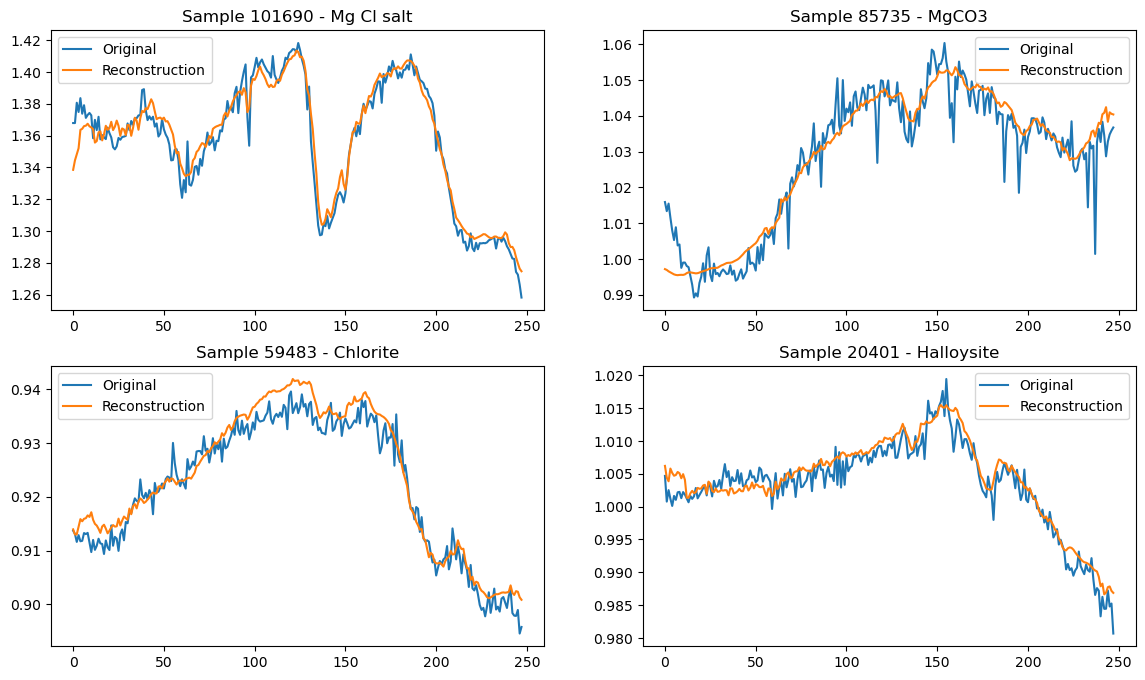

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
indices = np.random.randint(0, dataset_for_recon.data.shape[0], 4)
print(indices)

inputs = dataset_for_recon.data[indices]
max = torch.max(inputs, dim=-1, keepdim=True).values
min = torch.min(inputs, dim=-1, keepdim=True).values
scaled_inputs = (inputs - min) / (max - min)

recon = model.forward(scaled_inputs.unsqueeze(1), dataset_for_recon.labels[indices].unsqueeze(1))
recon = recon[0].squeeze()
# inverse scale
recon = recon * (max - min) + min
recon = recon.detach().numpy()

for i, idx in enumerate(indices):
    ax[i//2, i%2].plot(dataset_for_recon.data[idx][:248], label="Original")
    ax[i//2, i%2].plot(recon[i], label="Reconstruction")
    ax[i//2, i%2].set_title(f"Sample {idx} - {CLASS_NAMES[dataset_for_recon.labels[idx].item()]}")
    ax[i//2, i%2].legend()

In [ ]:
dataset = CRISMData(RATIOED_TEST_SET_PATH, transform=True, bands_to_use=(0, 248))

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/

In [ ]:
data_loader = DataLoader(dataset, batch_size=256, shuffle=False)
y_pred = []

for x, y in data_loader:
    y_pred.append(model.classify(x.unsqueeze(1)).detach().numpy())

In [9]:
y_pred_probs = torch.tensor(np.concatenate(y_pred, axis=0))
y_pred = torch.argmax(y_pred_probs, axis=1)

In [10]:
y_true = dataset.labels.squeeze()

In [11]:
def get_classification_report(predictions, labels, class_names):
    """
    Function to generate a classification report for a set of predictions.
    Parameters
    ----------
    predictions: np.ndarray
        Predicted class labels. Shape (n_samples,).
    labels: np.ndarray
        True class labels. Shape (n_samples,).

    Returns
    -------
    report: dict
        Sklearn classification report.
    """
    true_unique_classes = np.unique(labels)
    predicted_unique_classes = np.unique(predictions)
    classes_to_calculate_f1 = np.unique(np.concatenate((true_unique_classes, predicted_unique_classes)))
    string_classes = np.array([class_names[obs_class] for obs_class in classes_to_calculate_f1])

    report = classification_report(labels, predictions, target_names=string_classes, zero_division=0, output_dict=True)
    return report

First set of results use maximum granularity (all the classes provided in the Plebani dataset).

In [12]:
cost_matrix = CostMatrix(COST_ARRAY)
priors = np.full(38, 1 / 38) # uniform priors

In [13]:
report = get_classification_report(y_pred, y_true, CLASS_NAMES)
expected_cost = average_cost(y_true, y_pred, cost_matrix, priors)
print(f"Accuracy: {report['accuracy']}")
print(f"Macro F1: {report['macro avg']['f1-score']}")
print(f"Weighted F1: {report['weighted avg']['f1-score']}")
print(f"Precision: {report['macro avg']['precision']}")
print(f"Recall: {report['macro avg']['recall']}")
print(f"Expected Cost: {expected_cost}")

Accuracy: 0.8840190272451367
Macro F1: 0.7313236712681862
Weighted F1: 0.8837620600137078
Precision: 0.758836713377227
Recall: 0.7249417926495393
Expected Cost: 0.2593724137413793


In [14]:
unique_labels = np.unique(np.concatenate((np.unique(y_true), np.unique(y_pred))))
string_labels = [CLASS_NAMES[obs_class] for obs_class in unique_labels]

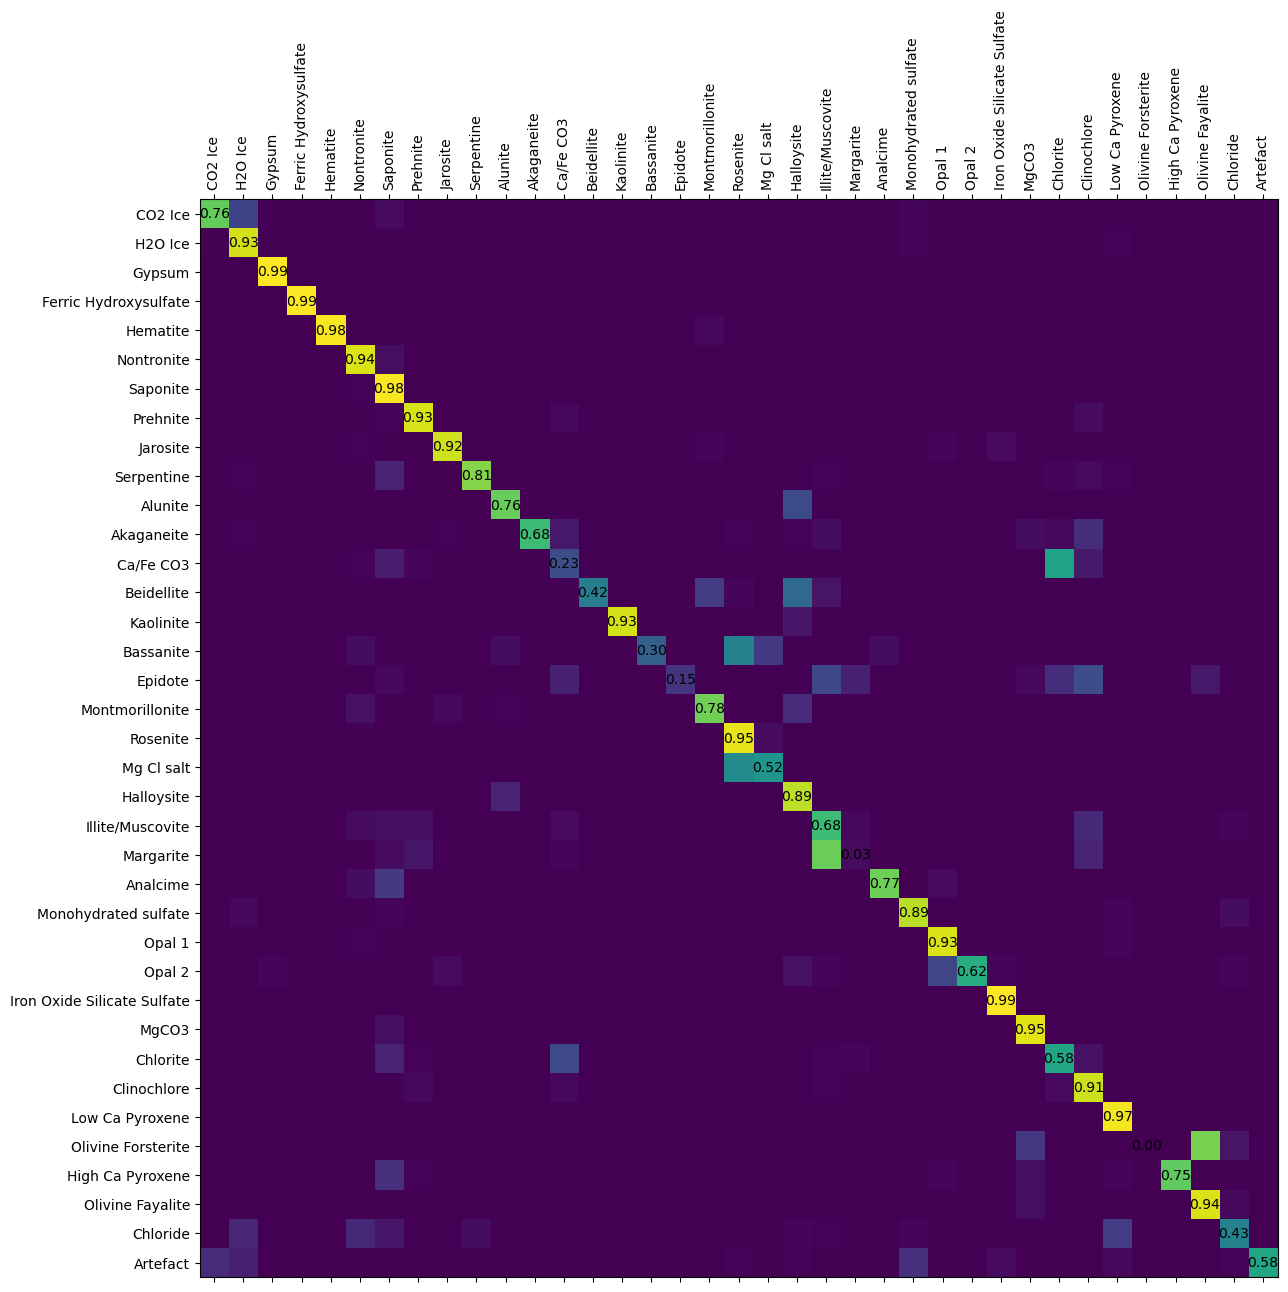

In [15]:
# take values from class_labels dict to list
cm = confusion_matrix(y_true, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(cm, cmap='viridis')
# add class labels to x and y axes
ax.set_xticks(range(len(string_labels)))
ax.set_yticks(range(len(string_labels)))
ax.set_xticklabels(string_labels, rotation=90)
ax.set_yticklabels(string_labels)
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(string_labels)):
    for j in range(len(string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')


Now group the classes into the super-classes used by the Plebani model

In [16]:
# first need to map the labels back to the FULL_NAMES as listed in crism_ml.lab
y_true_relabelled = labelling.change_pixel_label(y_true, in_val=21, out_val=38)
y_pred_relabelled = labelling.change_pixel_label(y_pred, in_val=21, out_val=38)

y_true_relabelled = labelling.make_array_zero_indexed(y_true_relabelled, forwards=False)
y_pred_relabelled = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=False)


In [17]:
y_true_relabelled = relabel(y_true_relabelled, ALIASES_TRAIN)
y_pred_relabelled = relabel(y_pred_relabelled, ALIASES_TRAIN)

In [18]:
# for expected cost the labels need to be zero indexed, otherwise the highest class number will be out of range
y_true_relabelled_zero = labelling.make_array_zero_indexed(y_true_relabelled, forwards=True)
y_pred_relabelled_zero = labelling.make_array_zero_indexed(y_pred_relabelled, forwards=True)

In [19]:
super_class_report = get_classification_report(y_pred_relabelled, y_true_relabelled, PLEBANI_CLASS_NAMES)
super_class_expected_cost = average_cost(y_true_relabelled_zero, y_pred_relabelled_zero, cost_matrix, priors)
print(f"Super class accuracy: {super_class_report['accuracy']}")
print(f"Super class macro F1: {super_class_report['macro avg']['f1-score']}")
print(f"Super class weighted F1: {super_class_report['weighted avg']['f1-score']}")
print(f"Super class precision: {super_class_report['macro avg']['precision']}")
print(f"Super class recall: {super_class_report['macro avg']['recall']}")
print(f"Super class expected cost: {super_class_expected_cost}")

Super class accuracy: 0.8905324671936553
Super class macro F1: 0.774412839500578
Super class weighted F1: 0.8916620897623238
Super class precision: 0.8054716383157776
Super class recall: 0.7663398897175033
Super class expected cost: 0.21788555747650923


In [20]:
relabelled_unique_labels = np.unique(np.concatenate((np.unique(y_true_relabelled), np.unique(y_pred_relabelled))))
relabelled_string_labels = [PLEBANI_CLASS_NAMES[obs_class] for obs_class in relabelled_unique_labels]

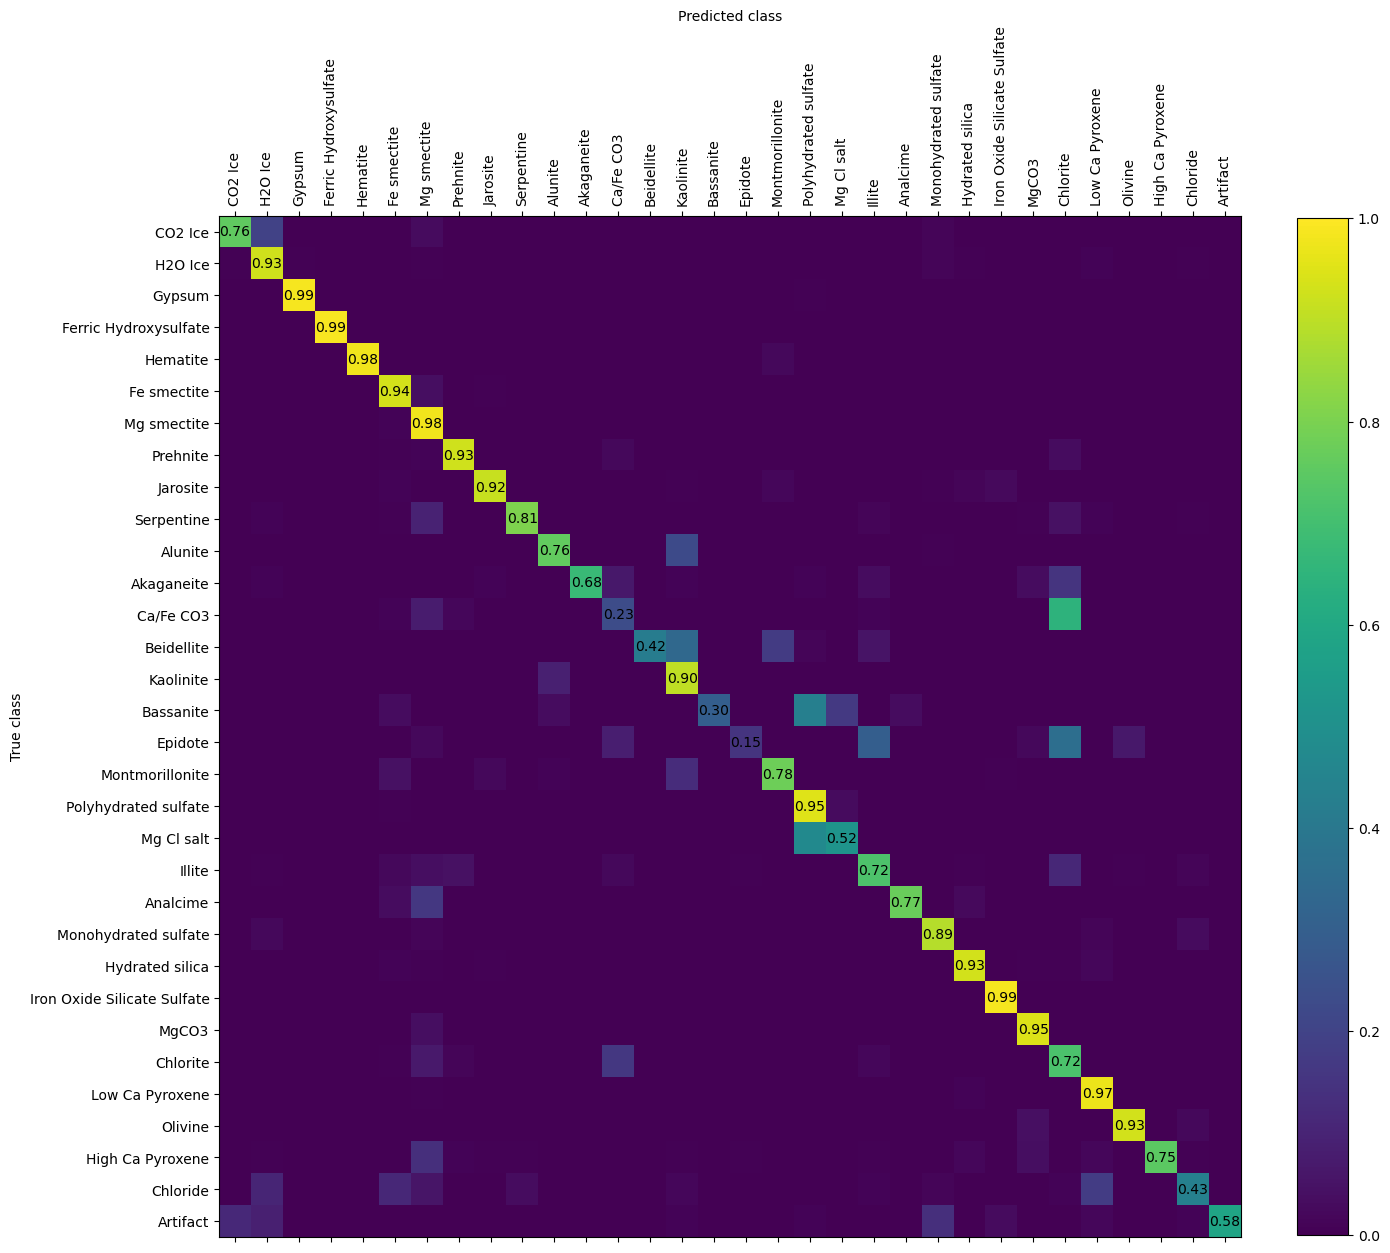

In [21]:
cm = confusion_matrix(y_true_relabelled, y_pred_relabelled, normalize="true")
fig, ax = plt.subplots(figsize=(14, 16))
ax.matshow(cm, cmap='viridis')
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(relabelled_string_labels)):
    for j in range(len(relabelled_string_labels)):
        if i != j:
            continue
        ax.text(j, i, f"{cm[i, j]:.2f}", ha='center', va='center', color='black')
fig.colorbar(mappable=ax.matshow(cm, cmap='viridis', vmin=0, vmax=1), fraction=0.045)
# add class labels to x and y axes
ax.set_xticks(range(len(relabelled_string_labels)))
ax.set_yticks(range(len(relabelled_string_labels)))
ax.set_xticklabels(relabelled_string_labels, rotation=90)
ax.set_yticklabels(relabelled_string_labels)
ax.set_ylabel("True class")
ax.set_xlabel("Predicted class") 
ax.xaxis.set_label_position('top') 
plt.tight_layout()
plt.show()


In [ ]:
np.save("confusion_matrix.npy", cm)

Calibration

In [ ]:
accuracies = y_pred.eq(y_true) # boolean tensor, true when prediction is correct
bin_bounds = torch.linspace(0, 1, 11) # ten bins
confidences = y_pred_probs.max(dim=1).values # confidence is the maximum probability
acc_bin, conf_bin, prop_bin = _binning_bucketize(confidences, accuracies, bin_bounds) # bucketize the probs/confs, the accuracies, and the proportion of data in each bin
# acc_bin gives the accuracy for each bin, conf_bin is the average confidence of the bin, and prop_bin is the proportion of data in each bin

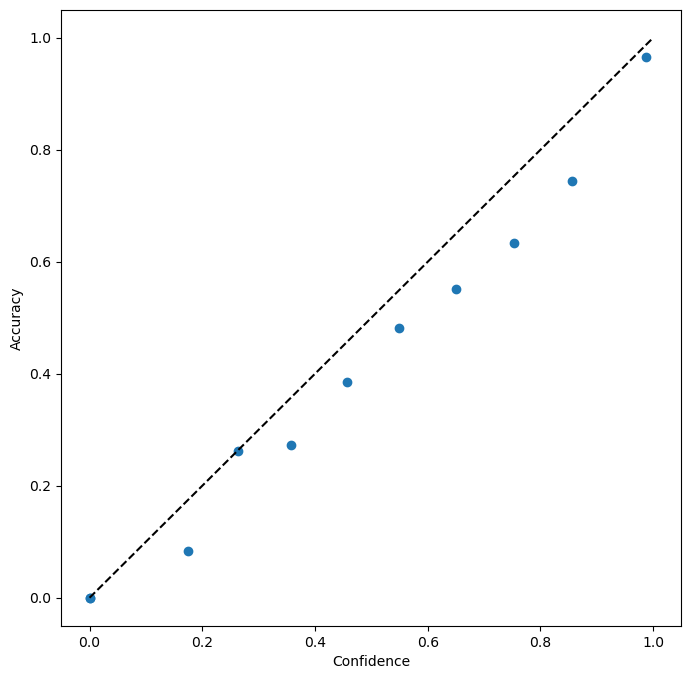

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(conf_bin, acc_bin)
ax.set_xlabel('Confidence')
ax.set_ylabel('Accuracy')
# add a diagonal line for reference
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

In [ ]:
torch.save(acc_bin, "hm4_accuracy_vals.pt")
torch.save(conf_bin, "hm4_confidence_vals.pt")

In [ ]:
torch.save(y_pred_probs, "hm4_pred_probs.pt")

In [28]:
print(f"Mean confidnece: {confidences.mean()}, minimum confidence {confidences.min()}, maximum confidence {confidences.max()}")

Mean confidnece: 0.9219614863395691, minimum confidence 0.10150568932294846, maximum confidence 0.9999998807907104


In [29]:
calibration_metric = MulticlassCalibrationError(num_classes=38, n_bins=10)
calibration_metric.update(y_pred_probs, y_true)
ece = calibration_metric.compute()
print(f"ECE: {ece}")

ECE: 0.03808387368917465
